In [1]:
!pip install -U libsvm-official

  Preparing metadata (setup.py) ... done
  Created wheel for libsvm-official: filename=libsvm_official-3.32.0-cp310-cp310-linux_x86_64.whl size=123882 sha256=5bf5dcc80b195b5a7b6cd270488a48935816ea4274bfffe76539134788e98724
  Stored in directory: /root/.cache/pip/wheels/61/3b/1b/73bb4869517f96a26c82b47ccdb9ec48f12f4466de2371eff6
Successfully built libsvm-official


In [2]:
from libsvm.svmutil import *
import shutil
import pandas as pd
import numpy as np
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cleaning

## Loading diabetes set

In [4]:
y, x = svm_read_problem('/content/drive/MyDrive/DeepLearning/Assignment 1/diabetes.txt')
x = pd.DataFrame(x)
y = pd.DataFrame(y)
df = pd.concat([x,y],axis = 1)

change 0 to NA

In [5]:
cols = [2,3,4,5,6]
x[cols] = x[cols].replace(0,np.NaN)

## Splitting

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_testval, y_train, y_testval = train_test_split (x,y, test_size = 0.2, random_state = 26, stratify= y)

X_val,X_test, y_val, y_test = train_test_split(X_testval,y_testval, test_size = 0.5, random_state = 26, stratify = y_testval)

## Imputation and standardisation

In [7]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp.fit(X_train)
X_train_imp = imp.transform(X_train)
X_val_imp = imp.transform(X_val)
X_test_imp = imp.transform(X_test)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_val_scaled = scaler.transform(X_val_imp)
X_test_scaled = scaler.transform(X_test_imp)

y_train_S = np.reshape(y_train.values, (-1))
y_test_S = np.reshape(y_test.values, (-1))
y_val_S = np.reshape(y_val.values,(-1))
X_train_S = X_train_scaled
X_val_S = X_val_scaled
X_test_S = X_test_scaled

#Single Perceptron Implementation

In [8]:
from sklearn.metrics import accuracy_score
class PerceptronClass():
    def __init__(self, stepsize, epoch, use_validation = True):
        self.W = None
        self.stepsize = stepsize
        self.epoch = epoch
        self.accuracy = []
        self.accuracy_score = []
        self.accuracy_test = []
        self.loss_hist=[]
        self.use_validation = use_validation

    def predict(self,x):
        y_pred = np.sign(np.dot(x,self.W))
        return y_pred

    def misclass(self,y,x):
        return y*self.predict(x) <= 0

    def train(self, X_train, y_train,X_test,y_test):
        n,features = X_train.shape
        self.W = np.zeros(features)
        max_acc = 0
        W_maxacc = np.zeros(features)
        loss_min = float('inf')

        for epoch in range(self.epoch):
            sum = 0
            loss = 0
            mis_count = 0
            for i in range(n):
                if self.misclass(y_train[i],X_train[i]):
                    sum += y_train[i]*X_train[i]
                    loss += y_train[i]*np.dot(X_train[i],self.W)
                    mis_count +=1

            self.accuracy.append((n-mis_count)/n)
            self.accuracy_test.append(self.test(X_test,y_test))
            self.loss_hist.append(loss)

            # Only weights with best accuracy is kept
            if self.accuracy_test[epoch] > max_acc:
                max_acc = self.accuracy_test[epoch]
                W_maxacc = self.W.copy()

            self.W += self.stepsize * sum

        if self.use_validation == True:
            self.W = W_maxacc

    def test(self,X_test,y_test):
        n_test,f_test = X_test.shape
        mis_count = 0
        for i in range(n_test):
            if self.misclass(y_test[i],X_test[i]):
                mis_count +=1
        return (n_test-mis_count)/n_test



In [9]:
classifier = PerceptronClass(0.1,500, use_validation = True)
classifier.train(X_train_S,y_train_S, X_val_S, y_val_S)

Text(0, 0.5, 'accuracy')

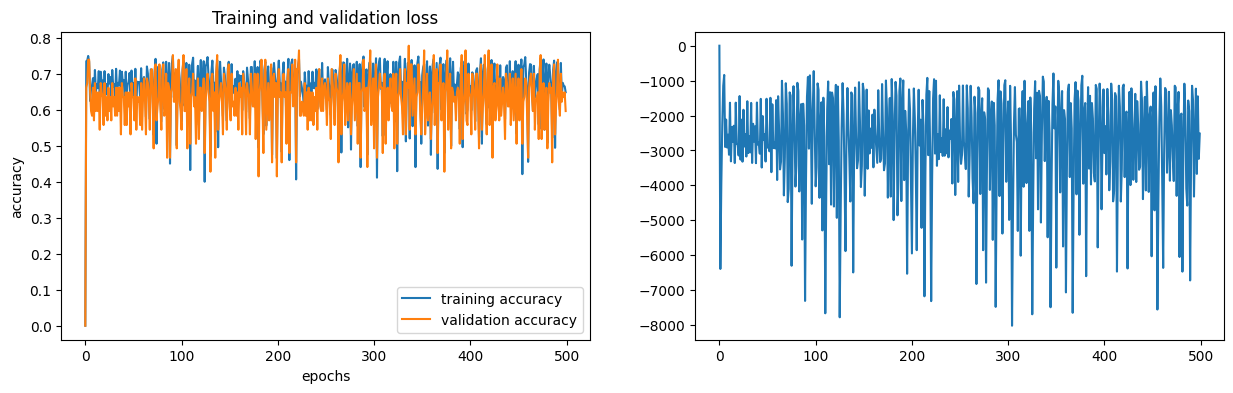

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(15,4))

ax[0].plot(classifier.accuracy, label = "training accuracy")
ax[0].plot(classifier.accuracy_test, label = "validation accuracy")
ax[1].plot(classifier.loss_hist)
ax[0].set_title('Training and validation loss')
ax[0].legend()
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")

In [11]:
classifier.test(X_test_S,y_test_S)

0.7272727272727273

# Scikit learn Perceptron

In [12]:
from sklearn.linear_model import Perceptron
clf = Perceptron(tol=1e-3)
clf.fit(X_train_S,y_train_S)

Perceptron()

In [13]:
clf.score(X_train_S,y_train_S)

0.6856677524429967

In [14]:
clf.score(X_test_S,y_test_S)

0.6493506493506493

# Perceptron Metrics Performance

In [15]:
from sklearn.metrics import classification_report

##Perceptron (implemented)

In [16]:
print(classification_report(y_test_S, classifier.predict(X_test_S), labels = [-1,1]))

              precision    recall  f1-score   support

          -1       0.58      0.78      0.67        27
           1       0.85      0.70      0.77        50

    accuracy                           0.73        77
   macro avg       0.72      0.74      0.72        77
weighted avg       0.76      0.73      0.73        77



## Perceptron (scikit learn)

In [17]:
print(classification_report(y_test_S, clf.predict(X_test_S), labels = [-1,1]))

              precision    recall  f1-score   support

          -1       0.50      0.19      0.27        27
           1       0.67      0.90      0.77        50

    accuracy                           0.65        77
   macro avg       0.59      0.54      0.52        77
weighted avg       0.61      0.65      0.59        77



# MLP


In [91]:
y_train_S[y_train_S<0] = 0
y_test_S[y_test_S<0] = 0
y_val_S[y_val_S<0] =0

In [159]:
import random
class MultiLayerPerceptron():
    def __init__ (self, inputSize, outputSize, hiddenLayerSize, numberLayers):

        self.accuracy = []
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.hiddenLayerSize = hiddenLayerSize
        self.numberLayers = numberLayers
        self.W1 = HiddenLayer(self.inputSize, self.hiddenLayerSize)
        self.Wn = HiddenLayer(self.hiddenLayerSize, self.outputSize)
        self.loss = torch.nn.BCELoss()
        self.loss_hist = []
        self.loss_test_hist = []
        self.accuracy_test =[]

        self.Weights = [self.W1]
        for i in range(1,self.numberLayers):
            self.Weights.append(HiddenLayer(self.hiddenLayerSize,self.hiddenLayerSize))
        #self.Weights.append(self.Wn)

    def activation(self,s):
        #return 1 / (1 + torch.exp(-s))
        function = torch.nn.ReLU()
        activate = function(s)
        return activate

    def sigmoid(self,s):
        function = torch.nn.Sigmoid()
        activate = function(s)
        return activate

    def linear(self, l, w):
        return torch.matmul(l,w)

    def forward(self, X_train):
        temp_result = X_train
        n = X_train.size(dim=0)
        for i in self.Weights:
            temp_result = self.activation(self.linear(temp_result,i.W))
        output = self.sigmoid(self.linear(temp_result, self.Wn.W))
        return output.view(n)

    def loss_function(self,y_train,X_train):
        y_pred = self.forward(X_train)
        loss = self.loss(y_pred, y_train)
        return loss

    def accuracy_score(self,y_pred,y_true):
        n = y_true.size(dim=0)
        return torch.sum(y_pred == y_true).item()/n*100

    def predict (self, X_train, threshold=0.5):
        y_pred = self.forward(X_train)
        y_pred[y_pred >= threshold] = 1
        y_pred[y_pred < threshold] = 0
        return y_pred

    def train(self,X_train,y_train,X_test,y_test, epochs, lr, threshold):
        X_train =torch.from_numpy(X_train)
        y_train = torch.from_numpy(y_train)
        X_test =torch.from_numpy(X_test)
        y_test = torch.from_numpy(y_test)
        patient = 5
        min_val_loss = float('inf')
        counter = 0

        for epoch in range(epochs):

            loss = self.loss_function(y_train,X_train)

            loss.backward()

            loss_test = self.loss_function(y_test,X_test)

            self.accuracy.append(self.accuracy_score(y_train,self.predict(X_train,threshold)))
            self.loss_hist.append(loss.item())

            self.loss_test_hist.append(loss_test.item())
            self.accuracy_test.append(self.accuracy_score(y_test,self.predict(X_test,threshold)))

            #Early stopping
            if loss_test.item() <= min_val_loss:
                min_val_loss = loss_test.item()
                counter = 0
            else:
                counter +=1
                if counter >= patient:
                    break

            with torch.no_grad():
                for weight in self.Weights:
                    weight.W -= weight.W.grad*lr
                    weight.W.grad.zero_()
                self.Wn.W -= self.Wn.W.grad*lr
                self.Wn.W.grad.zero_()


    def test(self,X_test,y_test):
        X_test =torch.from_numpy(X_test)
        y_test = torch.from_numpy(y_test)

        accuracy = self.accuracy_score(y_test,self.predict(X_test))
        loss = self.loss_function (y_test, X_test)
        return accuracy,loss


class HiddenLayer():
    def __init__(self,m,n):
        torch.manual_seed(100)
        #self.W = torch.randn(m,n, requires_grad = True, dtype = torch.float64)
        self.W = torch.empty(m,n,requires_grad=True, dtype = torch.float64)
        torch.nn.init.xavier_uniform_(self.W)

In [162]:
MLPclass = MultiLayerPerceptron(8,1,8,3)
MLPclass.train(X_train_S,y_train_S, X_val_S, y_val_S,10000, 0.01,0.5)

In [238]:
MLPclass.test(X_test_S, y_test_S)

(79.22077922077922, tensor(0.4339, grad_fn=<BinaryCrossEntropyBackward0>))

# Hyper-parameter tuning

In [223]:
layers = [1,2,3,4,5]
neurons = [1,2,4,8,16,32,64,128]

accuracy_val = np.empty((5,8))
count = 0
loss_test = np.empty((5,8))
loss_val = np.empty((5,8))
accuracy_test = np.empty((5,8))
for l in range(len(layers)):
  for n in range(len(neurons)):
      MLPclass = MultiLayerPerceptron(8,1,neurons[n],layers[l])
      MLPclass.train(X_train_S,y_train_S,X_val_S,y_val_S, 10000, 0.01,0.5)
      accuracy_val[l,n], loss_val [l,n] = MLPclass.test(X_val_S,y_val_S)
      #accuracy_test[l,n],loss_test[l,n] = MLPclass.test(X_test_S,y_test_S)
      count +=1
      print(f"Completed {count}/40 cycle")


Completed 1/40 cycle
Completed 2/40 cycle
Completed 3/40 cycle
Completed 4/40 cycle
Completed 5/40 cycle
Completed 6/40 cycle
Completed 7/40 cycle
Completed 8/40 cycle
Completed 9/40 cycle
Completed 10/40 cycle
Completed 11/40 cycle
Completed 12/40 cycle
Completed 13/40 cycle
Completed 14/40 cycle
Completed 15/40 cycle
Completed 16/40 cycle
Completed 17/40 cycle
Completed 18/40 cycle
Completed 19/40 cycle
Completed 20/40 cycle
Completed 21/40 cycle
Completed 22/40 cycle
Completed 23/40 cycle
Completed 24/40 cycle
Completed 25/40 cycle
Completed 26/40 cycle
Completed 27/40 cycle
Completed 28/40 cycle
Completed 29/40 cycle
Completed 30/40 cycle
Completed 31/40 cycle
Completed 32/40 cycle
Completed 33/40 cycle
Completed 34/40 cycle
Completed 35/40 cycle
Completed 36/40 cycle
Completed 37/40 cycle
Completed 38/40 cycle
Completed 39/40 cycle
Completed 40/40 cycle


## Test

In [241]:
y_pred_S = MLPclass.predict(torch.from_numpy(X_test_S))
y_pred_S = y_pred_S.detach().numpy()

In [243]:
print(classification_report(y_test_S, y_pred_S, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.68      0.78      0.72        27
           1       0.87      0.80      0.83        50

    accuracy                           0.79        77
   macro avg       0.77      0.79      0.78        77
weighted avg       0.80      0.79      0.80        77



In [245]:
report = pd.DataFrame(accuracy_val)

In [254]:
report

,1n,2n,4n,8n,16n,32n,64n,128n
1 hl,64.935065,74.025974,75.324675,75.324675,75.324675,72.727273,75.324675,74.025974
2 hl,64.935065,64.935065,74.025974,75.324675,76.623377,75.324675,76.623377,77.922078
3 hl,64.935065,64.935065,74.025974,79.220779,75.324675,75.324675,72.727273,77.922078
4 hl,64.935065,64.935065,64.935065,71.428571,75.324675,77.922078,76.623377,74.025974
5 hl,64.935065,64.935065,64.935065,79.220779,74.025974,77.922078,74.025974,75.324675


In [253]:
report = report.rename(columns = {0:"1n",1:"2n", 2:"4n", 3:"8n", 4: "16n", 5:"32n", 6: "64n", 7:"128n"})
report = report.rename(index = {0:"1 hl",1:"2 hl",2:"3 hl", 3:"4 hl", 4:"5 hl"})

In [257]:
report.transpose().round(3)

,1 hl,2 hl,3 hl,4 hl,5 hl
1n,64.935,64.935,64.935,64.935,64.935
2n,74.026,64.935,64.935,64.935,64.935
4n,75.325,74.026,74.026,64.935,64.935
8n,75.325,75.325,79.221,71.429,79.221
16n,75.325,76.623,75.325,75.325,74.026
32n,72.727,75.325,75.325,77.922,77.922
64n,75.325,76.623,72.727,76.623,74.026
128n,74.026,77.922,77.922,74.026,75.325


# Plot

With early stopping

Text(0, 0.5, 'loss')

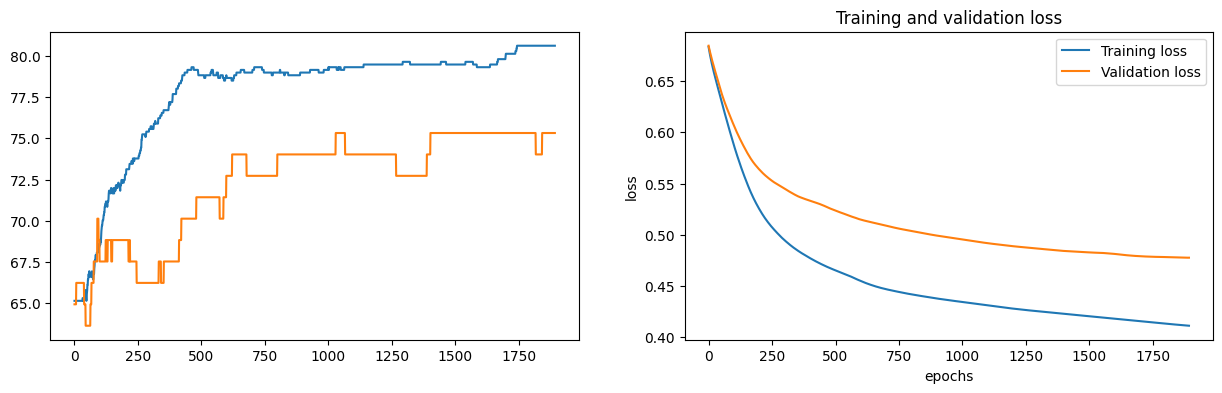

In [157]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(15,4))

ax[0].plot(MLPclass.accuracy)
ax[0].plot(MLPclass.accuracy_test)
ax[1].plot(MLPclass.loss_hist, label = "Training loss")
ax[1].plot(MLPclass.loss_test_hist, label = "Validation loss")

ax[1].set_title('Training and validation loss')
ax[1].legend()
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")

Without early stopping

Text(0, 0.5, 'loss')

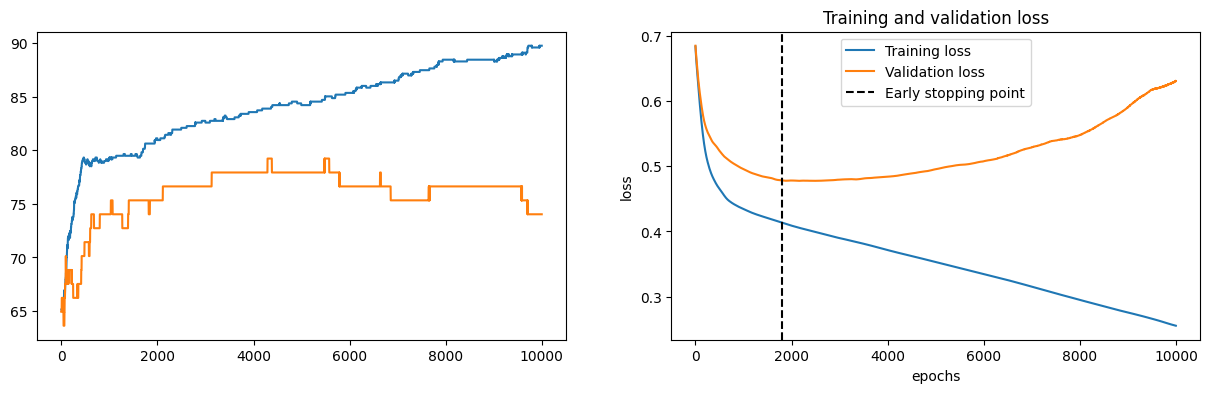

In [165]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(15,4))
#epochs = range(len(acc))

ax[0].plot(MLPclass.accuracy)
ax[0].plot(MLPclass.accuracy_test)
ax[1].plot(MLPclass.loss_hist, label = 'Training loss')
ax[1].plot(MLPclass.loss_test_hist, label = 'Validation loss')
ax[1].axvline(x = 1800, color = "black", linestyle = "dashed", label = "Early stopping point")

ax[1].set_title('Training and validation loss')
ax[1].legend()
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
